In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import shutil
import time
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style('darkgrid')

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
dir = r'/kaggle/input/lung-and-colon-data' 

file_paths = []
labels = []

for root, dirs, files in os.walk(dir):
    for classs in dirs:
        if classs in ["lung_image_sets", "colon_image_sets"]:
            continue  
        class_path = os.path.join(root, classs)
        flist = os.listdir(class_path)
        for f in flist:
            fpath = os.path.join(class_path, f)
            file_paths.append(fpath)
            labels.append(classs)

Fseries = pd.Series(file_paths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis=1)
df = data_df.reset_index(drop=True)  

print(df['labels'].value_counts())

labels
colon_aca    5000
colon_n      5000
lung_aca     5000
lung_scc     5000
lung_n       5000
Name: count, dtype: int64


In [11]:
sample_size = 5000 
sample_list = []
group = df.groupby('labels')
for label in df['labels'].unique():    
    label_group = group.get_group(label).sample(sample_size, 
                                                replace=False, 
                                                random_state=42, 
                                                axis=0)
    sample_list.append(label_group)
df = pd.concat(sample_list, axis=0).reset_index(drop=True)
print(f"Total after sampling: {len(df)}")

Total after sampling: 25000


In [12]:
train_split = 0.8
test_split = 0.1
val_split = 1 - (train_split + test_split)

train_df, remaining_df = train_test_split(df, 
                                          train_size=train_split, 
                                          shuffle=True, 
                                          random_state=42)
test_df, valid_df = train_test_split(remaining_df, 
                                     train_size=test_split / (test_split + val_split), 
                                     shuffle=True, 
                                     random_state=42)

print(f"train_df: {len(train_df)}, test_df: {len(test_df)}, valid_df: {len(valid_df)}")

train_df: 20000, test_df: 2500, valid_df: 2500


In [13]:
height = 224
width = 224
channels = 3
batch_size = 32
img_size = (height, width)

In [14]:
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter,RandomAffine,ToTensor,Normalize

In [15]:
train_transform = Compose([
    Resize(img_size),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=15),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    RandomAffine(degrees=0, translate=(0.1, 0.1)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet statistics
])

In [16]:
valid_transform = Compose([
    Resize(img_size),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet statistics
])

In [17]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.filepaths = dataframe['filepaths'].values
        self.labels = LabelEncoder().fit_transform(dataframe['labels'].values)
        self.transform = transform
        
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        file_path = self.filepaths[idx]
        label = self.labels[idx]
        image = Image.open(file_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [18]:
length = len(test_df)
test_batch_size = max([
    int(length / n) 
    for n in range(1, length + 1) 
    if length % n == 0 and length / n <= 80
])
test_steps = length // test_batch_size
print('Test batch size:', test_batch_size, 'Test steps:', test_steps)

Test batch size: 50 Test steps: 50


In [19]:
from sklearn.preprocessing import LabelEncoder

train_dataset = CustomDataset(train_df, transform=train_transform)
test_dataset = CustomDataset(test_df, transform=valid_transform)
valid_dataset = CustomDataset(valid_df, transform=valid_transform)

In [20]:
pin_mem = True if device.type == 'cuda' else False


In [21]:
train_loader = DataLoader(train_dataset, 
                         batch_size=batch_size, 
                         shuffle=True, 
                         num_workers=4,
                         pin_memory=pin_mem)
test_loader = DataLoader(test_dataset, 
                        batch_size=test_batch_size, 
                        shuffle=False, 
                        num_workers=4,
                        pin_memory=pin_mem)
valid_loader = DataLoader(valid_dataset, 
                         batch_size=batch_size, 
                         shuffle=False,  # No need to shuffle validation data
                         num_workers=4,
                         pin_memory=pin_mem)

In [22]:
classes = train_df['labels'].unique().tolist()
class_count = len(classes)
print(f"Found {len(train_dataset)} images for training belonging to {class_count} classes")
print(f"Found {len(test_dataset)} images for testing belonging to {class_count} classes")
print(f"Found {len(valid_dataset)} images for validating belonging to {class_count} classes")

Found 20000 images for training belonging to 5 classes
Found 2500 images for testing belonging to 5 classes
Found 2500 images for validating belonging to 5 classes


In [23]:
def display_image(loader, classes):
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    
    images_np = images.cpu().numpy()
    labels_np = labels.cpu().numpy()

    plt.figure(figsize=(20, 20))
    r = min(len(labels_np), 15)

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images_np[i].transpose(1, 2, 0) * 0.5) + 0.5
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        class_name = classes[labels_np[i]]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

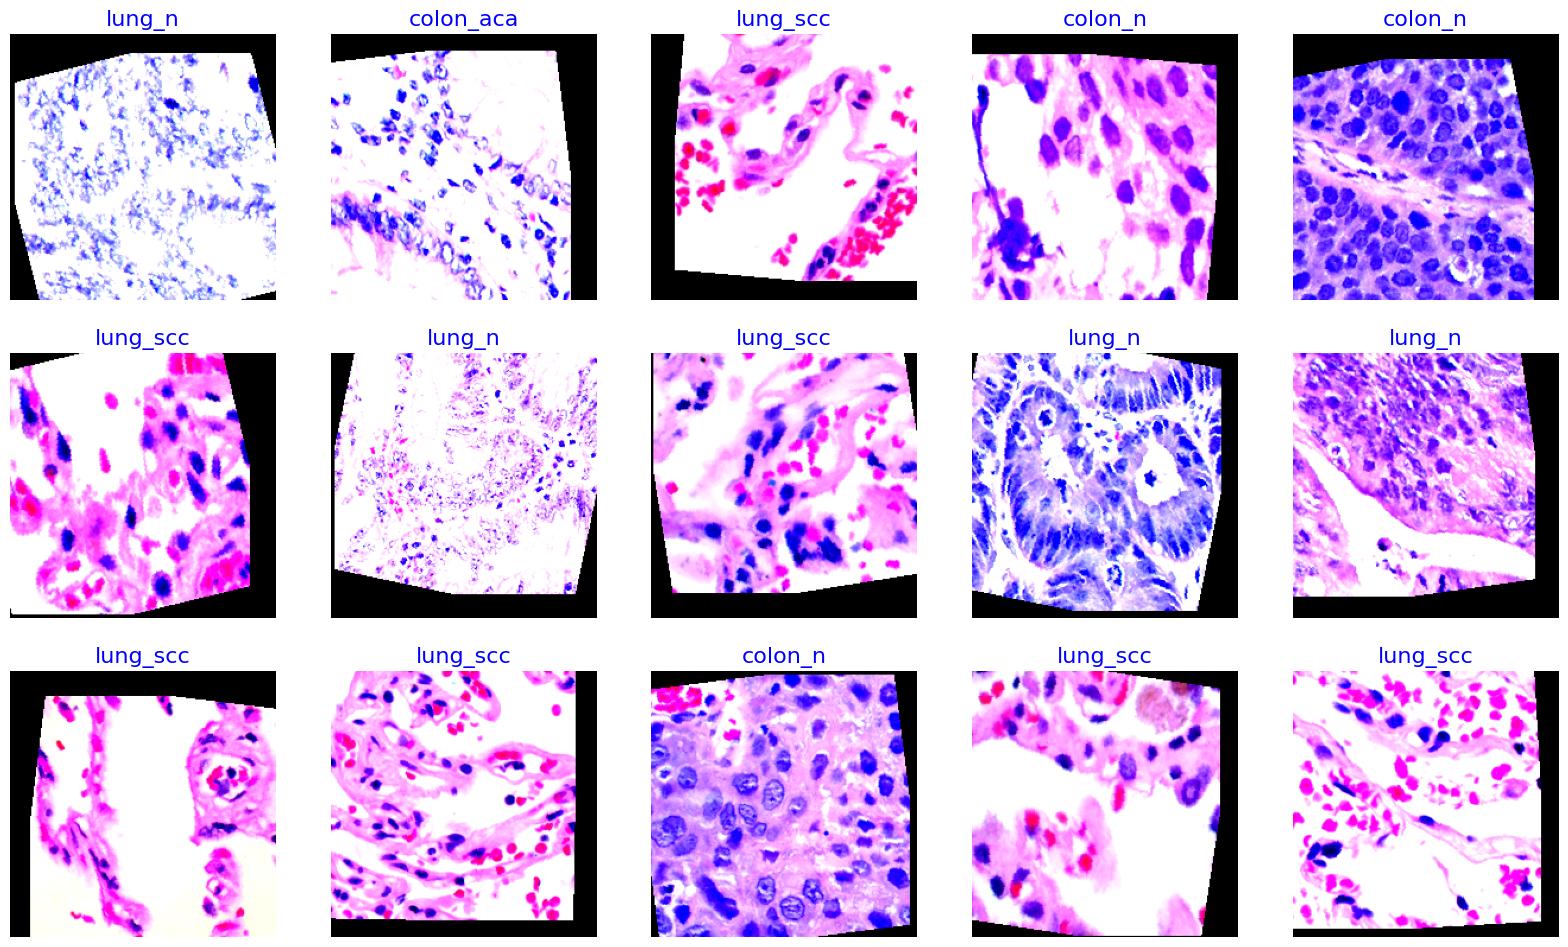

In [24]:
display_image(train_loader,classes)

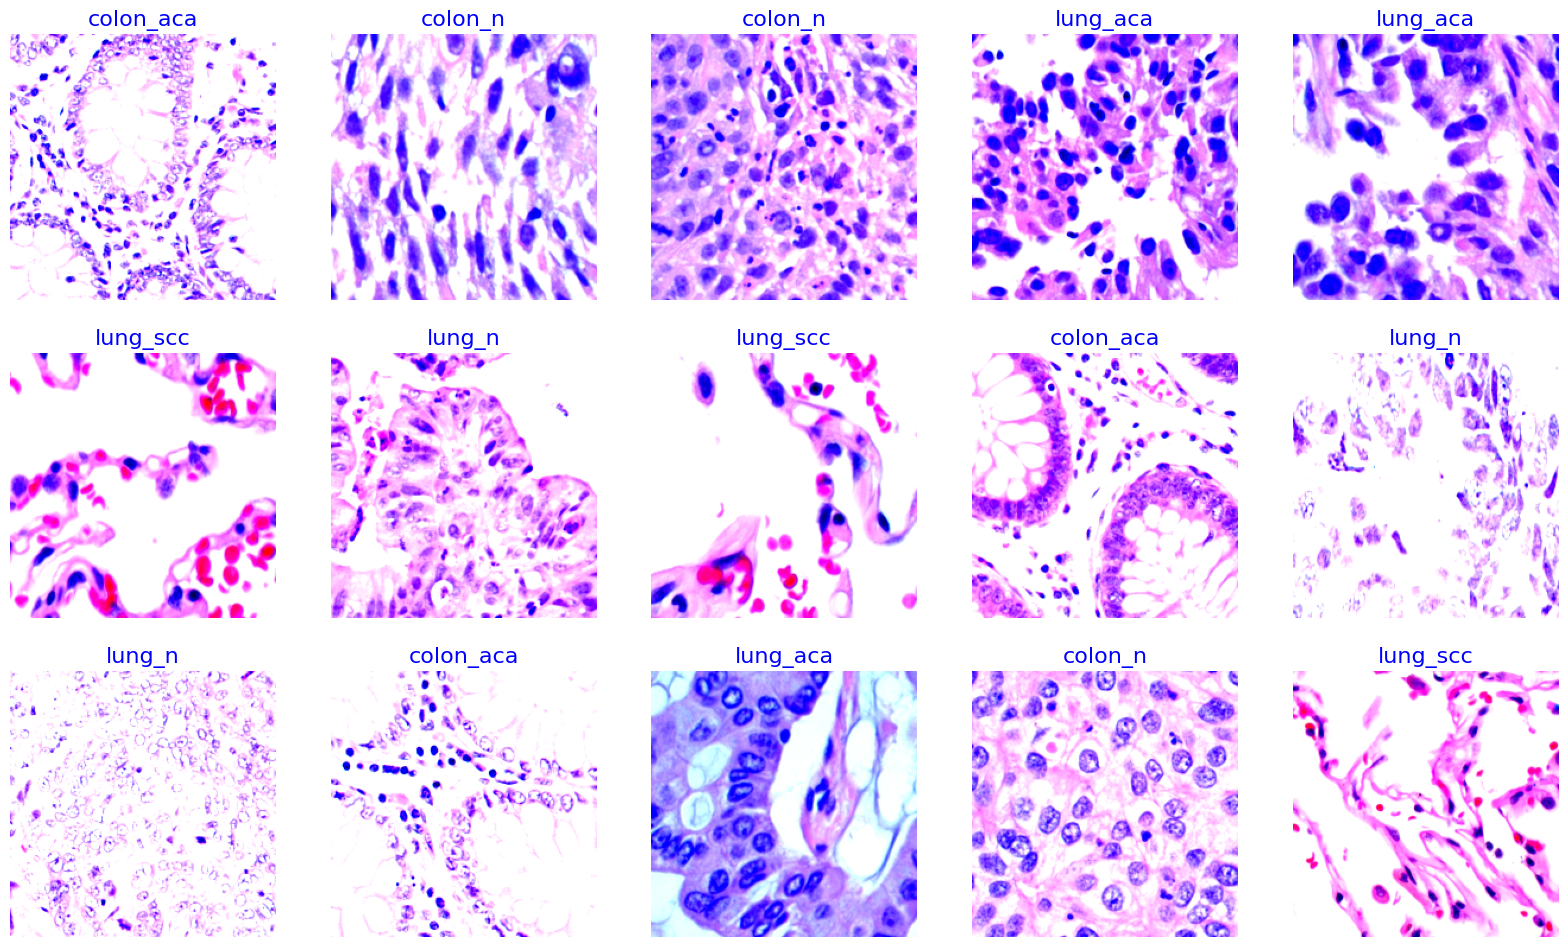

In [25]:
display_image(test_loader,classes)


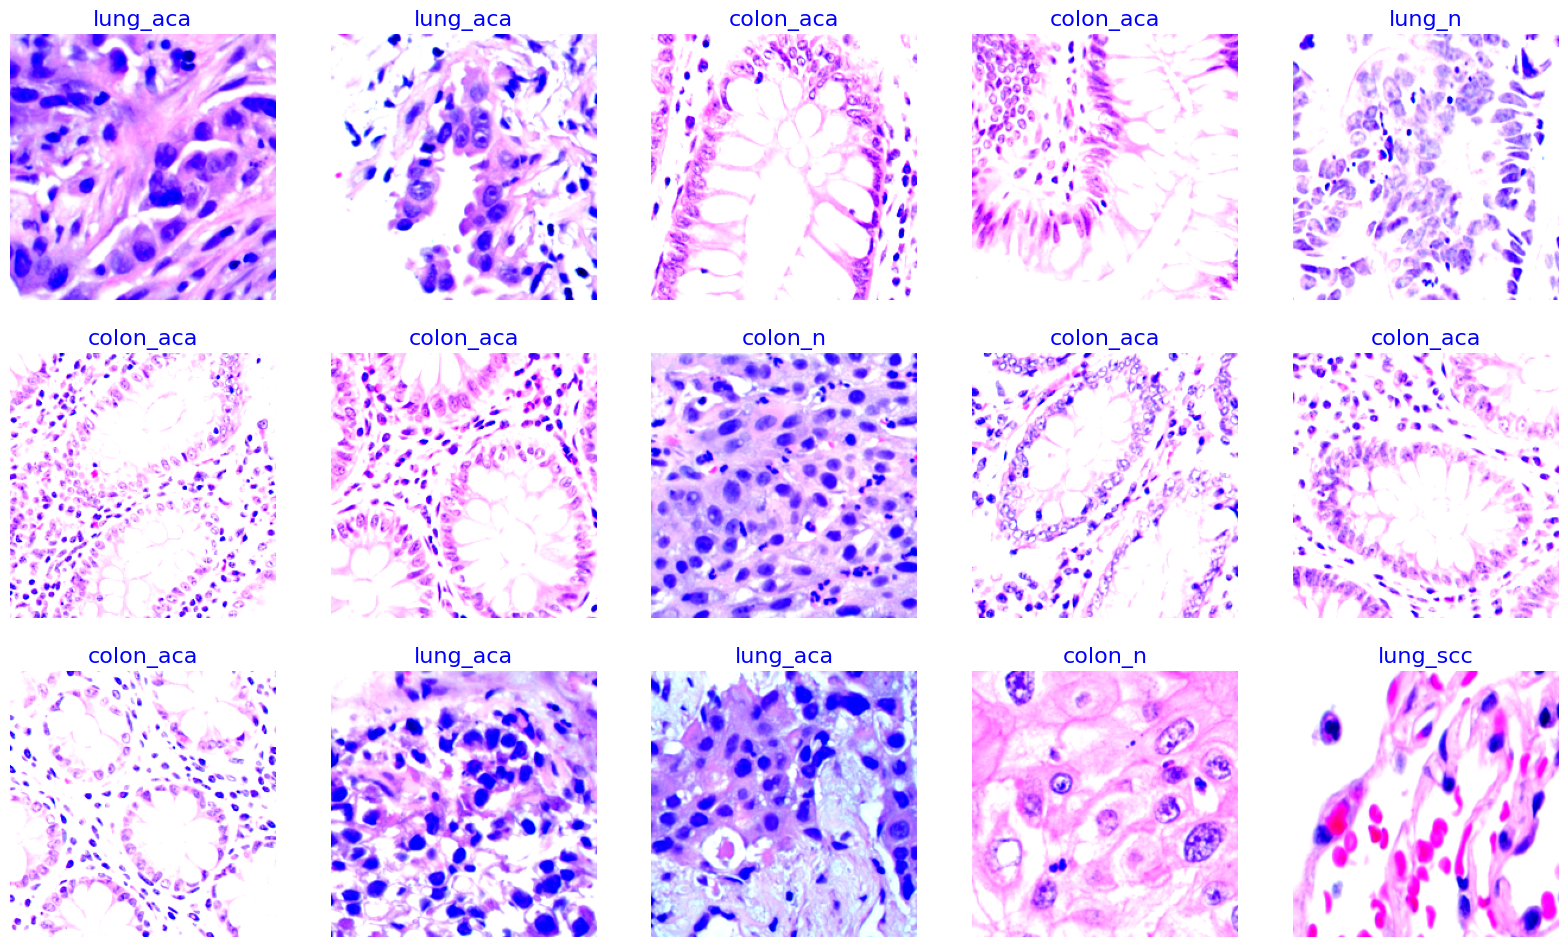

In [26]:
display_image(valid_loader,classes)

## **Convolution Vision Transformers implementation(CvT)**

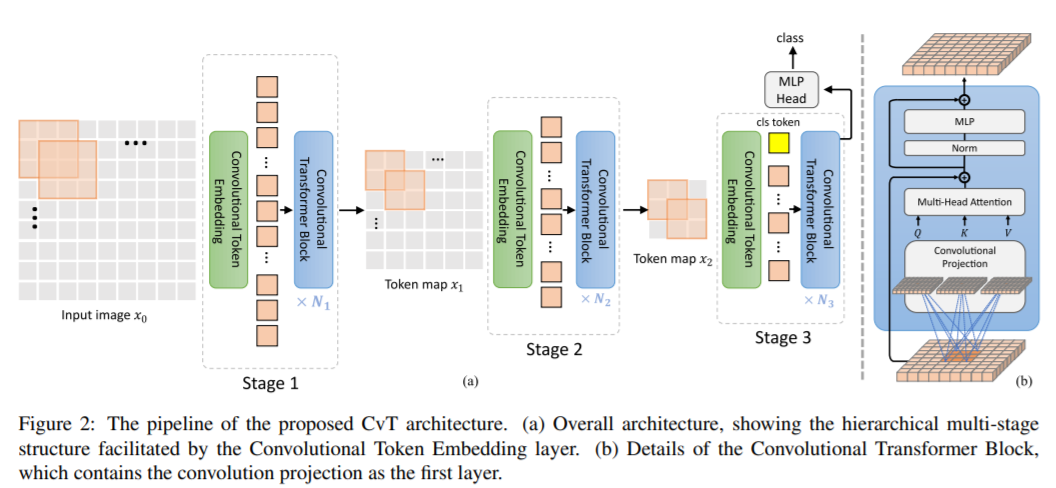
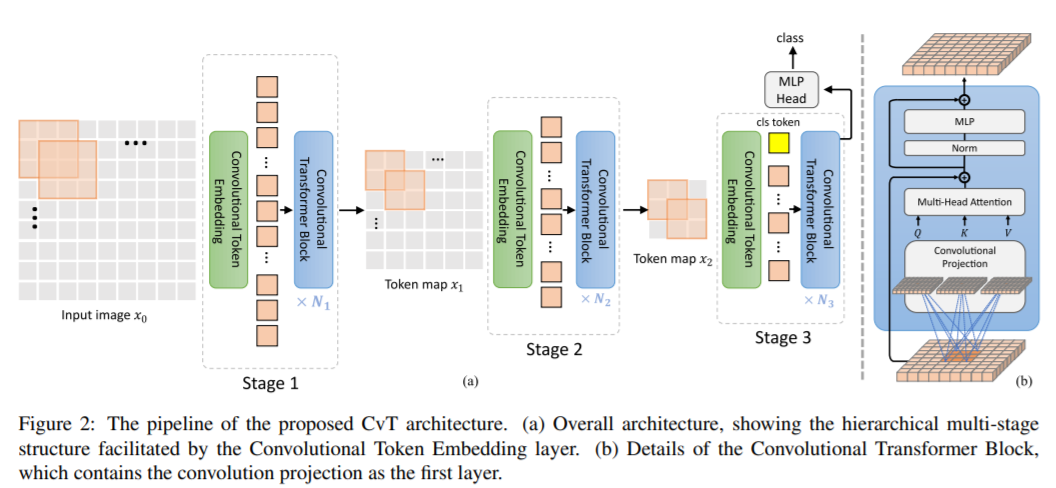

In [27]:
class ConvTokenEmbedding(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.LayerNorm(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        B, C, H, W = x.shape
        # [B, C, H, W] -> [B, H*W, C]
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x, H, W

In [28]:
class ConvolutionalAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0.0, proj_drop=0.0, 
                kernel_size=3, stride_kv=1, padding_kv=1, stride_q=1, padding_q=1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        # Convolutional projections for Q, K, V
        self.conv_q = nn.Conv2d(dim, dim, kernel_size, stride_q, padding_q, groups=dim, bias=qkv_bias)
        self.conv_k = nn.Conv2d(dim, dim, kernel_size, stride_kv, padding_kv, groups=dim, bias=qkv_bias)
        self.conv_v = nn.Conv2d(dim, dim, kernel_size, stride_kv, padding_kv, groups=dim, bias=qkv_bias)
        
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
    
    def forward(self, x, H, W):
        B, N, C = x.shape
        x_2d = x.transpose(1, 2).reshape(B, C, H, W)
        
        q = self.conv_q(x_2d).flatten(2).transpose(1, 2)  # [B, N, C]
        k = self.conv_k(x_2d).flatten(2).transpose(1, 2)  # [B, N, C]
        v = self.conv_v(x_2d).flatten(2).transpose(1, 2)  # [B, N, C]
        
        q = q.reshape(B, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # [B, num_heads, N, head_dim]
        k = k.reshape(B, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # [B, num_heads, N, head_dim]
        v = v.reshape(B, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # [B, num_heads, N, head_dim]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, -1, C)
        
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x

In [29]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, qkv_bias=False, drop=0.1, attn_drop=0.1,
                kernel_size=3, stride_kv=1, padding_kv=1, stride_q=1, padding_q=1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = ConvolutionalAttention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop,
            kernel_size=kernel_size, stride_kv=stride_kv, padding_kv=padding_kv,
            stride_q=stride_q, padding_q=padding_q
        )
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(drop)
        )
    
    def forward(self, x, H, W):
        x = x + self.attn(self.norm1(x), H, W)
        x = x + self.mlp(self.norm2(x))
        return x, H, W

In [30]:
class Stage(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, 
                depth, num_heads, mlp_ratio=4., qkv_bias=False, drop=0.1, attn_drop=0.1):
        super().__init__()
        
        self.embedding = ConvTokenEmbedding(in_channels, out_channels, kernel_size, stride, padding)
        
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(
                out_channels, num_heads, mlp_ratio, qkv_bias, drop, attn_drop
            ) for _ in range(depth)
        ])
    
    def forward(self, x):
        x, H, W = self.embedding(x)
        
        for block in self.transformer_blocks:
            x, H, W = block(x, H, W)
            
        # [B, N, C] -> [B, C, H, W]
        B, N, C = x.shape
        x = x.transpose(1, 2).reshape(B, C, H, W)
        
        return x

In [31]:
class CvT(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000, stages_config=None, drop_path_rate=0.1):
        super().__init__()
        
        # Stage configurations according to the CvT paper
        if stages_config is None:
            stages_config = [
                # Stage 1
                {
                    'out_channels': 64,
                    'kernel_size': 7,
                    'stride': 4,
                    'padding': 3,
                    'depth': 1,
                    'num_heads': 1,
                    'mlp_ratio': 4.0,
                    'drop_rate': 0.0,
                    'attn_drop_rate': 0.0
                },
                # Stage 2
                {
                    'out_channels': 192,
                    'kernel_size': 3,
                    'stride': 2,
                    'padding': 1,
                    'depth': 2,
                    'num_heads': 3,
                    'mlp_ratio': 4.0,
                    'drop_rate': 0.1,
                    'attn_drop_rate': 0.1
                },
                # Stage 3
                {
                    'out_channels': 384,
                    'kernel_size': 3,
                    'stride': 2,
                    'padding': 1,
                    'depth': 10,
                    'num_heads': 6,
                    'mlp_ratio': 4.0,
                    'drop_rate': 0.2,
                    'attn_drop_rate': 0.2
                }
            ]
        
        # Create stages
        self.stages = nn.ModuleList()
        for i, stage_config in enumerate(stages_config):
            if i == 0:
                stage_in_channels = in_channels
            else:
                stage_in_channels = stages_config[i-1]['out_channels']
                
            self.stages.append(
                Stage(
                    in_channels=stage_in_channels,
                    out_channels=stage_config['out_channels'],
                    kernel_size=stage_config['kernel_size'],
                    stride=stage_config['stride'],
                    padding=stage_config['padding'],
                    depth=stage_config['depth'],
                    num_heads=stage_config['num_heads'],
                    mlp_ratio=stage_config['mlp_ratio'],
                    drop=stage_config.get('drop_rate', 0.0),
                    attn_drop=stage_config.get('attn_drop_rate', 0.0)
                )
            )
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Dropout before classifier
        self.dropout = nn.Dropout(0.2)
        
        # Classification head
        self.mlp_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(stages_config[-1]['out_channels'], num_classes)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        for stage in self.stages:
            x = stage(x)
        
        x = self.global_pool(x)
        x = self.dropout(x)
        x = self.mlp_head(x)
        
        return x

In [32]:
def train_model(model, train_loader, valid_loader, epochs=50, lr=2e-4, device='cuda', patience=5):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    criterion = nn.CrossEntropyLoss()
    
    # Learning rate scheduler with warmup
    def warmup_cosine_schedule(epoch):
        warmup_epochs = 2
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        else:
            return 0.5 * (1.0 + np.cos(np.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_cosine_schedule)
    
    # Initialize lists to store losses and accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    no_improve_epochs = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_acc = train_correct / train_total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = val_correct / val_total
        val_losses.append(val_loss / len(valid_loader))
        val_accuracies.append(val_acc)
        
        # Update scheduler
        scheduler.step()
        
        # Print progress
        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {train_losses[-1]:.4f} | '
              f'Train Acc: {train_accuracies[-1]:.4f} | '
              f'Val Loss: {val_losses[-1]:.4f} | '
              f'Val Acc: {val_accuracies[-1]:.4f} | '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')
        
        # Save best model and check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_cvt_model.pth')
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            
        # Early stopping
        if no_improve_epochs >= patience:
            print(f'Early stopping after {epoch+1} epochs with no improvement')
            break
    
    # Load the best model
    model.load_state_dict(torch.load('best_cvt_model.pth'))
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [33]:
def evaluate_model(model, test_loader, device='cuda'):
    model = model.to(device)
    model.eval()
    test_correct = 0
    test_total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    test_acc = test_correct / test_total
    print(f'Test Accuracy: {test_acc:.4f}')
    
    # Generate and print classification report
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("Classification Report:")
    print(report)
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return test_acc, report, cm

In [34]:
model = CvT(
    in_channels=channels, 
    num_classes=class_count,
    stages_config=[
        # Stage 1 - lighter with less parameters
        {
            'out_channels': 64,
            'kernel_size': 7,
            'stride': 4,
            'padding': 3,
            'depth': 1,
            'num_heads': 1,
            'mlp_ratio': 4.0,
            'drop_rate': 0.0,
            'attn_drop_rate': 0.0
        },
        # Stage 2 - medium depth
        {
            'out_channels': 192,
            'kernel_size': 3,
            'stride': 2,
            'padding': 1,
            'depth': 4,  # Increased from 2
            'num_heads': 3,
            'mlp_ratio': 4.0,
            'drop_rate': 0.1,
            'attn_drop_rate': 0.1
        },
        # Stage 3 - deep with more attention heads
        {
            'out_channels': 384,
            'kernel_size': 3,
            'stride': 2,
            'padding': 1,
            'depth': 12,  # Increased from 10
            'num_heads': 6,
            'mlp_ratio': 4.0,
            'drop_rate': 0.2,
            'attn_drop_rate': 0.2
        }
    ]
)

In [35]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 18,277,893
Trainable parameters: 18,277,893


In [36]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, 
    train_loader, 
    valid_loader, 
    epochs=10,  
    lr=2e-4,    
    device=device,
    patience=5 
)

Epoch 1/10 | Train Loss: 1.7079 | Train Acc: 0.2354 | Val Loss: 1.7615 | Val Acc: 0.1948 | LR: 0.000100
Epoch 2/10 | Train Loss: 0.6415 | Train Acc: 0.7323 | Val Loss: 0.3093 | Val Acc: 0.8816 | LR: 0.000200
Epoch 3/10 | Train Loss: 0.4276 | Train Acc: 0.8376 | Val Loss: 0.2617 | Val Acc: 0.9072 | LR: 0.000192
Epoch 4/10 | Train Loss: 0.3126 | Train Acc: 0.8797 | Val Loss: 0.3233 | Val Acc: 0.8868 | LR: 0.000171
Epoch 5/10 | Train Loss: 0.2366 | Train Acc: 0.9115 | Val Loss: 0.1973 | Val Acc: 0.9252 | LR: 0.000138
Epoch 6/10 | Train Loss: 0.1806 | Train Acc: 0.9317 | Val Loss: 0.1847 | Val Acc: 0.9332 | LR: 0.000100
Epoch 7/10 | Train Loss: 0.1392 | Train Acc: 0.9475 | Val Loss: 0.1338 | Val Acc: 0.9540 | LR: 0.000062
Epoch 8/10 | Train Loss: 0.1130 | Train Acc: 0.9567 | Val Loss: 0.0798 | Val Acc: 0.9672 | LR: 0.000029
Epoch 9/10 | Train Loss: 0.0882 | Train Acc: 0.9673 | Val Loss: 0.0854 | Val Acc: 0.9716 | LR: 0.000008
Epoch 10/10 | Train Loss: 0.0748 | Train Acc: 0.9733 | Val Loss:

<ipython-input-32-04ea39414f8c>:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cvt_model.pth'))


Test Accuracy: 0.9764
Classification Report:
              precision    recall  f1-score   support

      lung_n       0.99      1.00      1.00       504
   colon_aca       1.00      1.00      1.00       514
    lung_aca       0.95      0.93      0.94       503
    lung_scc       0.99      1.00      0.99       491
     colon_n       0.95      0.95      0.95       488

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



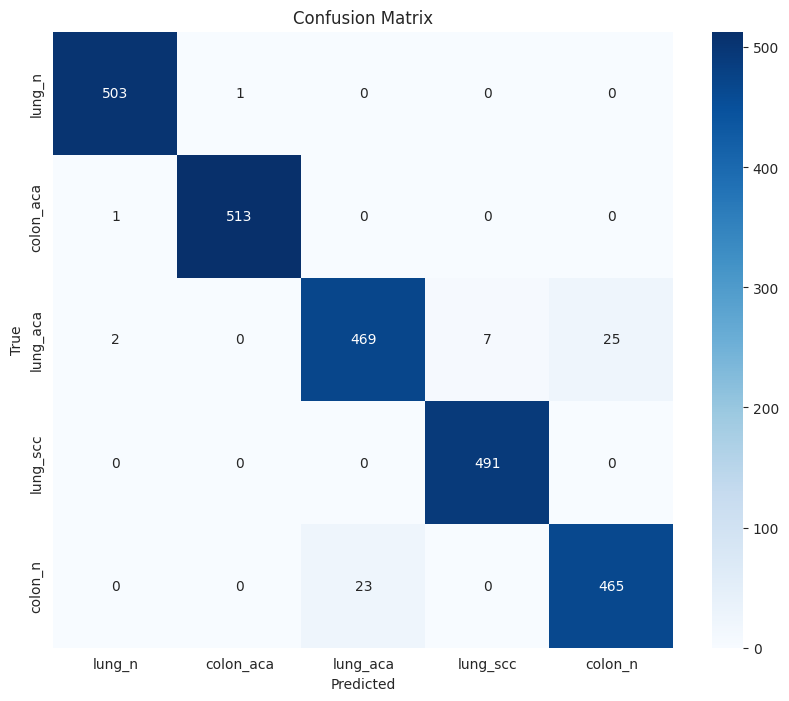

In [37]:
test_acc, report, cm = evaluate_model(model, test_loader, device)

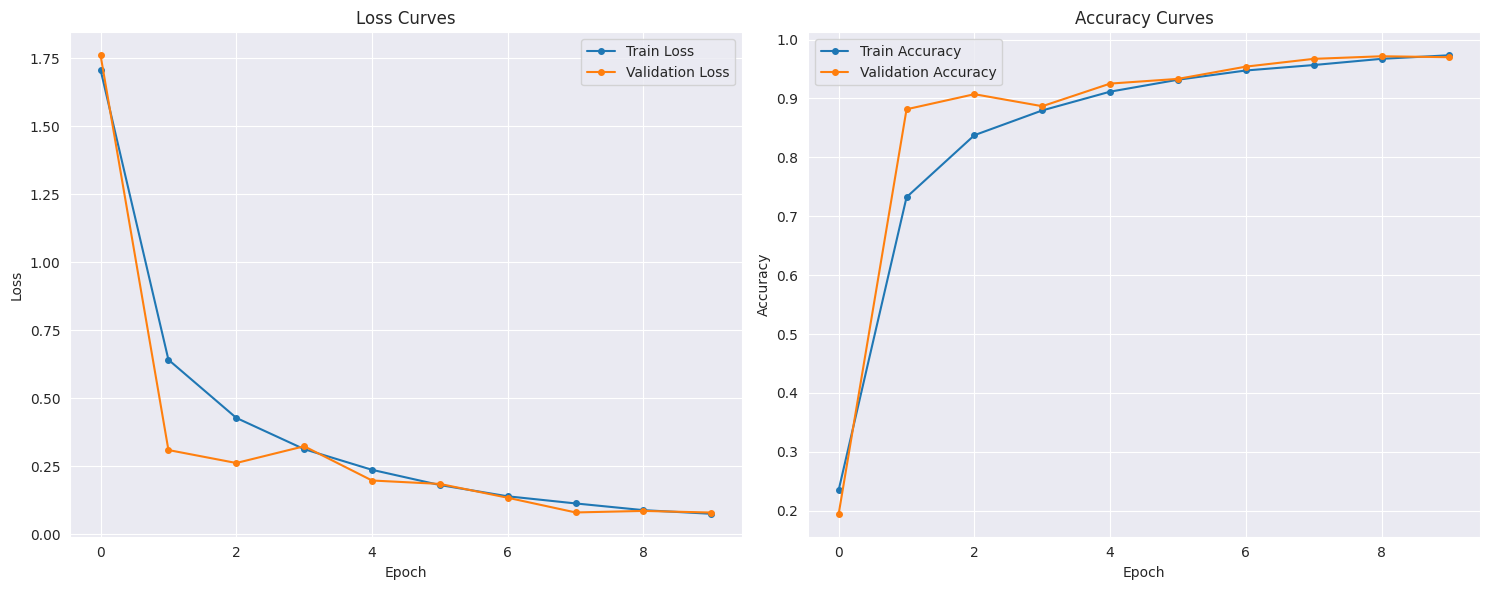

In [38]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(15, 6))
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o', markersize=4)
    plt.plot(val_losses, label='Validation Loss', marker='o', markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o', markersize=4)
    plt.plot(val_accuracies, label='Validation Accuracy', marker='o', markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)